In [265]:
from skimage.io import imread
import numpy as np
from scipy.fftpack import dct, idct
from matplotlib import pyplot as plt
import time


In [266]:
rootfolder = '.'

Useful function for plot the 2D DCT dictionary

In [267]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Load the image and rescale it in $[0,1]$

In [268]:
# img = imread(f'{rootfolder}/data/cameraman.png') / 255
# img = imread(f'{rootfolder}/data/barbara.png') / 255
img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [269]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [270]:
psnr_noisy = 10 * np.log10(1/ np.square(np.subtract(img, noisy_img)).mean())

Text(0.5, 1.0, 'Noisy image, PSNR = 22.12')

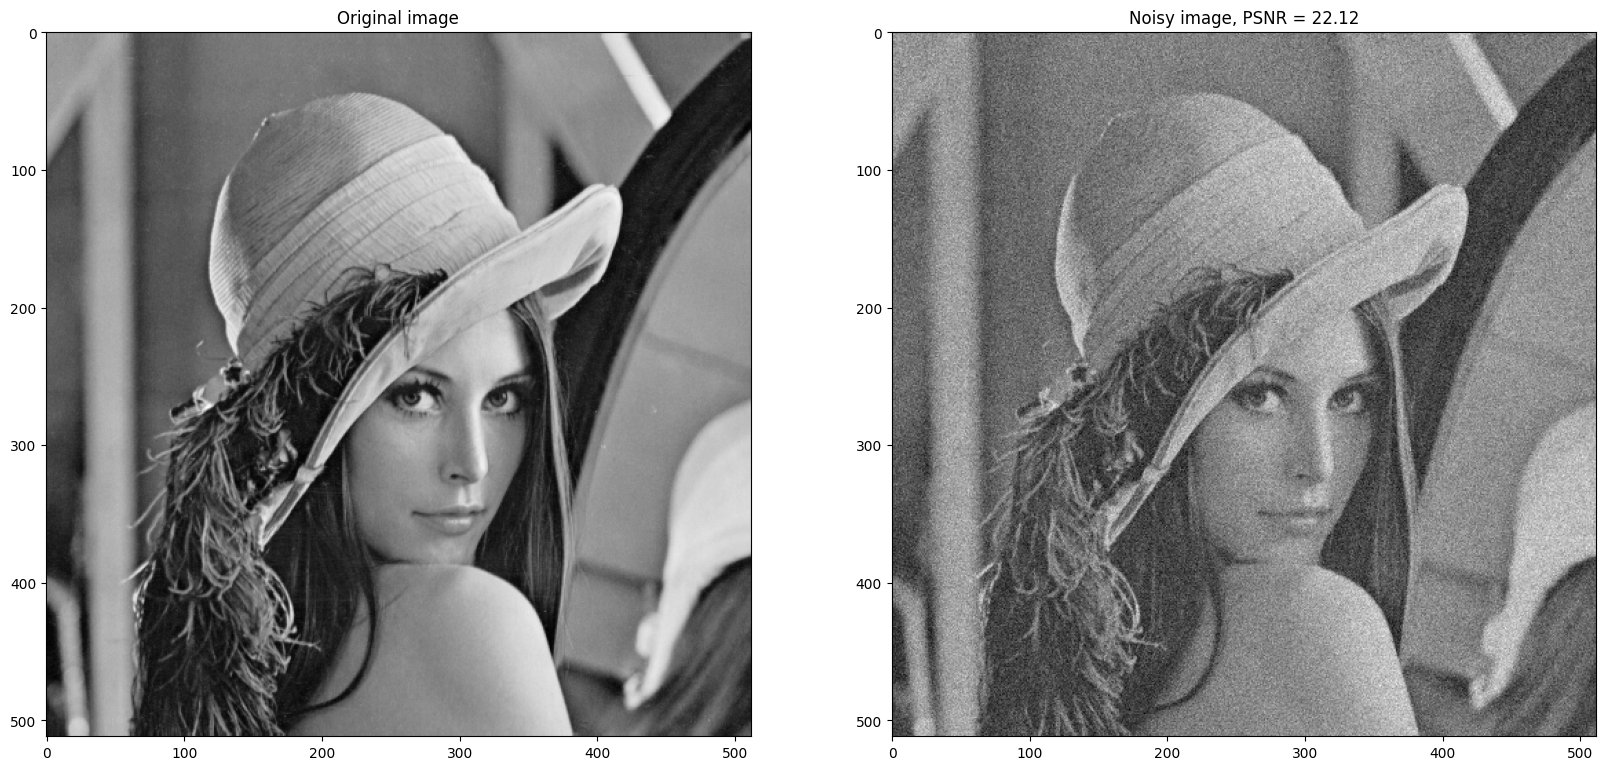

In [271]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Generate the Global PCA basis for this image
--------------------------------------------

Set the parameters for denoising

In [272]:
# set the threshold for the Hard Thresholding
tau = 3 * sigma_noise # Donoho says: sigma * sqrt(2*log(p^2))

Stack all the image patches in a large matrix $S$. Each patch goes in a column of $S$

In [273]:
# Stack all the image patches in a large matrix $S$. Each patch goes in a column of $S$
S = np.zeros((M, (imsz[0] - p + 1) * (imsz[1] - p + 1)))
k = 0
for i in range(imsz[0] - p + 1):
    for j in range(imsz[1] - p + 1):
        patch = noisy_img[i:i+p, j:j+p]
        S[:, k] = patch.flatten()
        k += 1

Compute $\tilde S$ by zero centering $S$


In [274]:
avg_patch = np.mean(S, axis=0)
Stilde = S - avg_patch

Compute the PCA transformation via SVD


In [275]:
U, Sigma, V = np.linalg.svd(np.dot(Stilde,Stilde.T))

Show the learned PCA basis

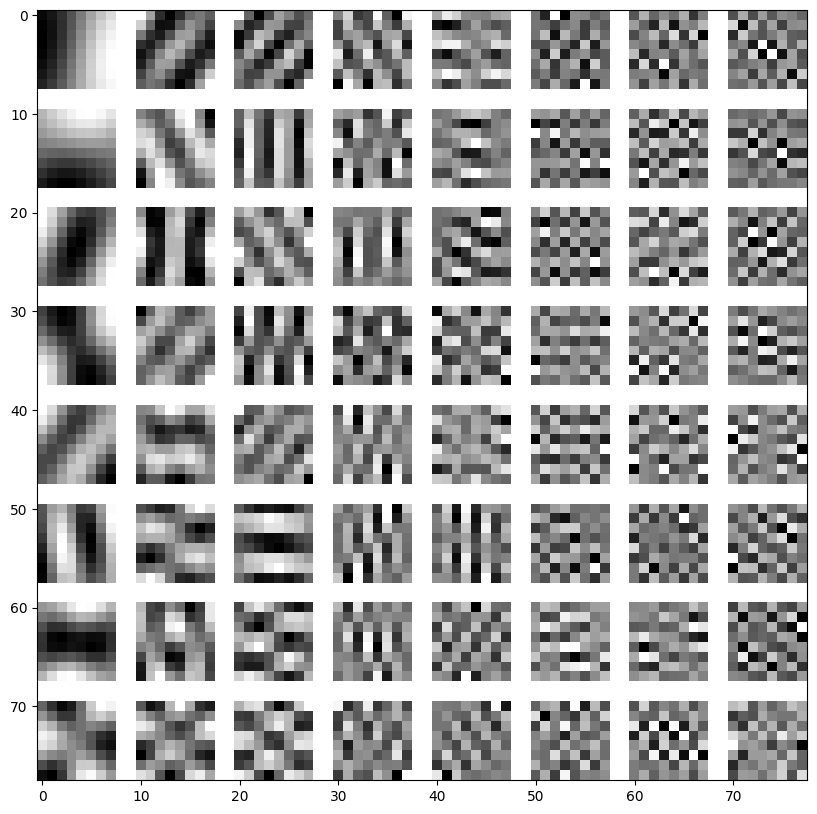

In [276]:
U_img = get_dictionary_img(U)
plt.figure(figsize=(10,10))
plt.imshow(U_img, cmap='gray')


Patch-based denoising
---------------------
Initialize the variables

In [277]:
STEP = 1

# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

In [278]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extract the patch with the top left corner at pixel (ii, jj)
        s = S[:, i * (imsz[1] - p + 1) + j]

        # Preprocessing: remember to subtract the avg_patch (preprocessing used for PCA)
        s = s - avg_patch[i * (imsz[1] - p + 1) + j]

        # compute the representation w.r.t. the PCA basis
        x_hat = np.dot(U.T, s)
        # perform the hard thresholding
        x_hat = np.multiply(x_hat, np.abs(x_hat) > tau)
        # synthesis: perform the reconstruction
        y_hat = np.dot(U, x_hat)

        # add the avg patch back
        y_hat = y_hat + avg_patch[i * (imsz[1] - p + 1) + j]

        # compute the weight for the reconstructed patch
        w = 1

        # put the compressed patch into the compressed image using the computed weight
        # UPDATE img_hat
        img_hat[i:i+p, j:j+p] += y_hat.reshape((p, p)) * w

        # store the weight of the current patch in the weight matrix
        # UPDATE weights
        weights[i:i+p, j:j+p] += w

# normalize the estimated image with the computed weights
img_hat = img_hat / weights


Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 32.20')

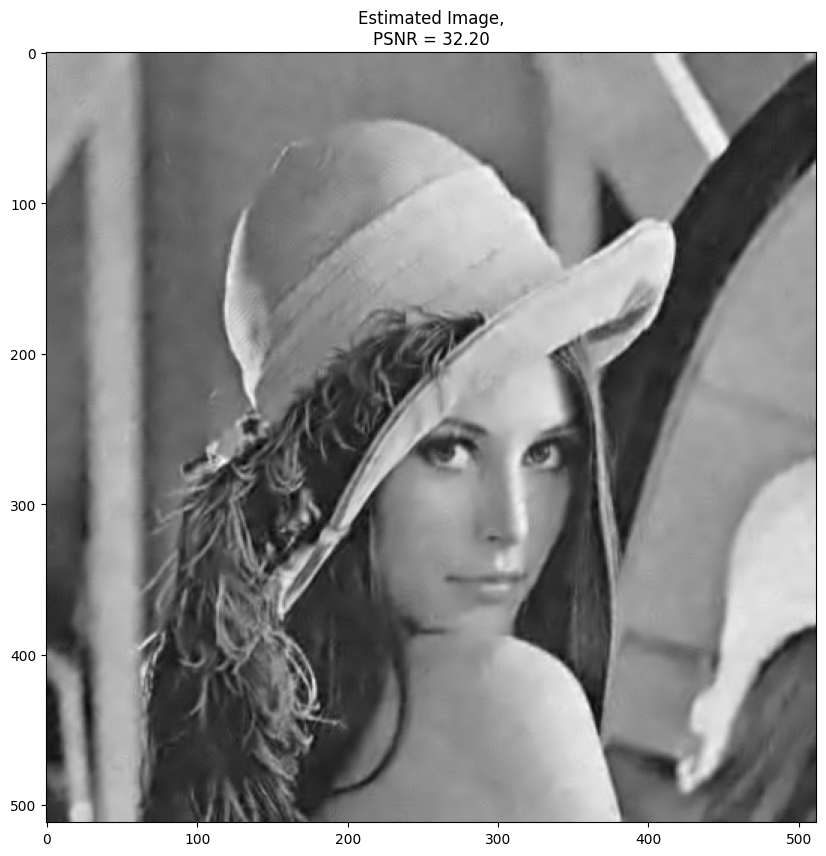

In [279]:
psnr_hat = 10 * np.log10(1/ np.square(np.subtract(img,img_hat)).mean())
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
